___

# Machine Learning in Geosciences ] 
Department of Applied Geoinformatics and Carthography, Charles University

Lukas Brodsky lukas.brodsky@natur.cuni.cz


## Python-gdal rasters


Thi notebook introduces how to work with raster data in Python using gdal binding. It covers: 

* 1. Reading raster data into Numpy ndarray

* 2. RGB image visualization

* 3. Simple map algebra 

* 4. Writing raster data into raster data file; 


### Setup

In [8]:
# Common imports for reading, visualizing
import os
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

# import gdal
from osgeo import gdal 

# Set your own PATH!!! 
PATH = '/Users/lukasbrodsky/Work/Prfuk/Vyuka/Machine_Learning_in_Geosciences/mlgeo/python-gdal/data/'

if os.path.isdir(PATH): 
    print('ok')

ok


In [9]:
import osgeo.gdal
print(osgeo.gdal.__version__)

2.3.2


### Get data 

In [10]:
raster_fn = os.path.join(PATH, 'landsat.tif')

In [11]:
if os.path.isfile(raster_fn): 
    print('ok')
else: 
    print('Check your path to the raster file!')

ok


### Reading raster

In [12]:
# driver 
driver = gdal.GetDriverByName('Gtiff')

In [13]:
driver

<osgeo.gdal.Driver; proxy of <Swig Object of type 'GDALDriverShadow *' at 0x11ba4ba80> >

In [14]:
# open
ds = gdal.Open(raster_fn) 
if ds is None: 
    print('Could not open {}'.format(fn)) 
    sys.exit(1) 


In [15]:
ds

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x10e926900> >

In [16]:
# raster dimensions 
cols = ds.RasterXSize
rows = ds.RasterYSize
bands = ds.RasterCount

print('The ../{} raster dimensionos are: '.format(os.path.basename(raster_fn)))
print('{} cols, {} rows and {} bands'.format(cols, rows, bands))

The ../landsat.tif raster dimensionos are: 
500 cols, 500 rows and 6 bands


In [17]:
# geotransform information
geotransform = ds.GetGeoTransform()
originX = geotransform[0]
originY = geotransform[3]
pixelWidth = geotransform[1]
pixelHeight = geotransform[5]

print('The ../{} raster georeference info is: '.format(os.path.basename(raster_fn)))
print('origin X: {}, origin Y: {} and pixel size is: {}'.format(originX, originY, pixelWidth))

The ../landsat.tif raster georeference info is: 
origin X: 624000.0, origin Y: 7750000.0 and pixel size is: 30.0


In [18]:
# value of pixel x, y 
x1 = 631608
y1 = 7744535

xOffset = int((x1 - originX) / pixelWidth)
yOffset = int((y1 - originY) / pixelHeight)

# get band from datasource
band = ds.GetRasterBand(1)
# get data from band
data1 = band.ReadAsArray(xOffset, yOffset, 1, 1)
print('Pixal value for x {} and y {} is {}'.format(x1, y1, data1[0]))

Pixal value for x 631608 and y 7744535 is [7384]


In [19]:
# vector of spectral values 
data1_vector = []
for b in range(ds.RasterCount): 
    band = ds.GetRasterBand(b + 1)
    data1_vector.append(band.ReadAsArray(xOffset, yOffset, 1, 1)[0][0] / 10000)

print(data1_vector)

[0.7384, 0.7925, 0.8097, 0.6591, 0.0138, 0.0118]


In [20]:
# value of pixel x, y 
x2 = 635150
y2 = 7739676

xOffset2 = int((x2 - originX) / pixelWidth)
yOffset2 = int((y2 - originY) / pixelHeight)

# vector of spectral values 
data2_vector = []
for b in range(ds.RasterCount): 
    band = ds.GetRasterBand(b + 1)
    data2_vector.append(band.ReadAsArray(xOffset2, yOffset2, 1, 1)[0][0] / 10000)

print(data2_vector)

[0.0579, 0.0851, 0.0994, 0.2204, 0.255, 0.1761]


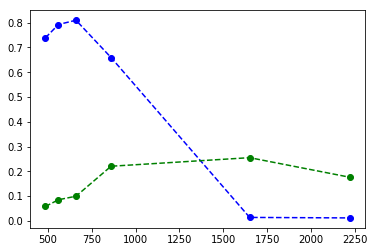

In [21]:
landsat_wavelength = [485, 560, 660, 860, 1650, 2220]

plt.plot(landsat_wavelength, data1_vector, 'bo--')
plt.plot(landsat_wavelength, data2_vector, 'go--')

In [22]:
# read full image 
data = band.ReadAsArray()
print('The image size is {}'.format(data.shape))

The image size is (500, 500)


In [23]:
# clean memory 
band = None
ds = None

### Writing raster

In [24]:
# read image data bands to Numpy
driver = gdal.GetDriverByName('Gtiff')
ds = gdal.Open(raster_fn) 

if ds is None: 
    print('Could not open {}'.format(fn)) 
    sys.exit(1) 


img = np.zeros((ds.RasterYSize, ds.RasterXSize, ds.RasterCount), dtype=np.float) 

for b in range(ds.RasterCount): 
    img[:, :, b] = ds.GetRasterBand(b + 1).ReadAsArray() / 10000


In [25]:
img.shape

(500, 500, 6)

In [26]:
# get meta
projection = ds.GetProjection()
geo_transform = ds.GetGeoTransform()

In [27]:
img.shape

(500, 500, 6)

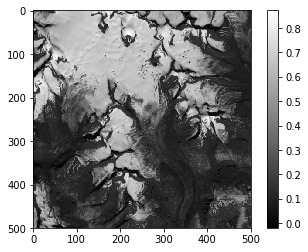

In [28]:
plt.imshow(img[:,:,3], cmap='gray')
plt.colorbar()

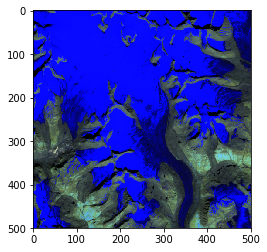

In [32]:
# view raster RGB using matplotlib 
index = np.array([5, 4, 3])
colors = img[:, :, index].astype(np.float64)
max_val = 0.4
min_val = 0.0

# enforce maximum and minimum values
colors[colors[:, :, :] > max_val] = max_val
colors[colors[:, :, :] < min_val] = min_val

for b in range(colors.shape[2]):
    colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)

plt.imshow(colors)

In [37]:
# calculate snow (ice) index 
# NDSI = (GREEN - SWIR1) / (GREEN + SWIR1)
GREEN_ix = 1
SWIR1_ix = 4
NDSI = (img[:,:,GREEN_ix] - img[:,:,SWIR1_ix]) - (img[:,:,GREEN_ix] + img[:,:,SWIR1_ix])

NDSI.shape

(500, 500)

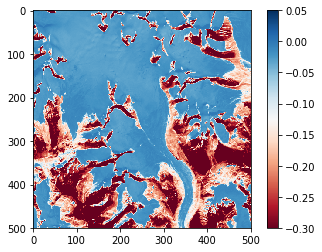

In [38]:
plt.imshow(NDSI, interpolation='none', cmap='RdBu', vmin=-0.3, vmax=0.05)
plt.colorbar()

In [39]:
# save the new image
filename = os.path.join(PATH, 'ndsi.tif')
outDataset = driver.Create(filename, ds.RasterYSize, ds.RasterXSize, 1, gdal.GDT_Float32)

In [40]:
# band to save 
# outBand = outDataset.GetRasterBand(1)
# outBand.WriteArray(NDSI)

outBand = outDataset.GetRasterBand(1).WriteArray(NDSI)

In [ ]:
# set no data value 
outBand.SetNoDataValue(-9999)

In [41]:
projection

'PROJCS["WGS 84 / UTM zone 21N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-57],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32621"]]'

In [42]:
# set projection to datasource 
outDataset.SetProjection(projection)

0

In [43]:
# set geotransform 
outDataset.SetGeoTransform(geo_transform)

0

In [44]:
outDataset = None

In [45]:
os.path.isfile(filename)

True